# Experimental Agreement Analysis: SL Overlap Between Training and Test Sets

This notebook analyzes the overlap and agreement of synthetic lethal (SL) gene pairs between training and test datasets. 

This analysis helps evaluate the reproducibility and consistency of SL predictions across different experimental screens.

In [1]:
# import modules
import os
import pandas as pd
import numpy as np
import random
import pickle

# import scikit-learn modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score, average_precision_score, precision_recall_curve, auc, roc_curve

# import visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cwd = os.getcwd()
BASE_DIR = os.path.abspath(os.path.join(cwd, ".."))

# build paths inside the repo
get_data_path = lambda folders, fname: os.path.normpath(
    os.path.join(BASE_DIR, *folders, fname)
)

file_path_training_data = get_data_path(['output', 'models'], 'training_data.csv')
klingbeil_file_path = get_data_path(['output', 'models'], 'testing_data.csv')

# Output
#file_RF_model_early = get_data_path(['output', 'models'], 'early_integration_model.pickle')
#file_RF_model_late = get_data_path(['output', 'models'], 'late_integration_model.pickle')

figure_path_roc_auc = get_data_path(['figures'], '4a_roc_auc.png')
figure_path_pr_auc = get_data_path(['figures'], '4b_pr_auc.png')


In [3]:
training_df = pd.read_csv(file_path_training_data)
training_df[:3]

,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr,GEMINI,LFC,SL_new
0,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.118768,0.088856,False
1,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.132501,0.201704,False
2,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.024593,0.069772,False


In [4]:
test_df = pd.read_csv(klingbeil_file_path)
test_df[:3]

,GENE_COMBINATION,domain_combination,genepair,A1,A2,A1_entrez,A2_entrez,cell_line,DepMap_ID,GEMINI,...,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr,SL_new
0,AAK1:Kinase_domain;BMP2K:Kinase_domain,Kinase_domain_Kinase_domain,AAK1_BMP2K,AAK1,BMP2K,22848.0,55589.0,HEL,ACH-000004,0.218665,...,False,0.0,0.0,False,77.0,21.867726,0.261701,6.713555,6.761786,False
1,AAK1:Kinase_domain;BMP2K:Kinase_domain,Kinase_domain_Kinase_domain,AAK1_BMP2K,AAK1,BMP2K,22848.0,55589.0,T3M4,ACH-000085,0.205641,...,False,0.0,0.0,False,77.0,21.867726,0.261701,6.713555,6.761786,False
2,AAK1:Kinase_domain;BMP2K:Kinase_domain,Kinase_domain_Kinase_domain,AAK1_BMP2K,AAK1,BMP2K,22848.0,55589.0,HPAFII,ACH-000094,0.044486,...,False,0.0,0.0,False,77.0,21.867726,0.261701,6.713555,6.761786,False


In [5]:
# Create combination keys for training and test
training_keys = set(zip(training_df['genepair'], training_df['DepMap_ID']))
test_keys = set(zip(test_df['genepair'], test_df['DepMap_ID']))

# Find overlapping pairs (seen in both train and test)
common_keys = training_keys & test_keys
uncommon_keys = test_keys - training_keys

print(f"Overlapping (seen) pairs: {len(common_keys)}")
print(f"Unseen pairs: {len(uncommon_keys)}")

# Filter test for seen and unseen pairs
test_seen_pairs_df = test_df[test_df.apply(lambda row: (row['genepair'], row['DepMap_ID']) in common_keys, axis=1)].copy()
test_unseen_pairs_df = test_df[test_df.apply(lambda row: (row['genepair'], row['DepMap_ID']) in uncommon_keys, axis=1)].copy()

print(f"Test seen pairs: {test_seen_pairs_df.shape[0]}")
print(f"Test unseen pairs: {test_unseen_pairs_df.shape[0]}")

# Filter train for seen and unseen pairs
train_seen_pairs_df = training_df[training_df.apply(lambda row: (row['genepair'], row['DepMap_ID']) in common_keys, axis=1)].copy()
train_unseen_pairs_df = training_df[training_df.apply(lambda row: (row['genepair'], row['DepMap_ID']) in uncommon_keys, axis=1)].copy()

print(f"Train seen pairs: {train_seen_pairs_df.shape[0]}")
print(f"Train unseen pairs: {train_unseen_pairs_df.shape[0]}")

Overlapping (seen) pairs: 994
Unseen pairs: 34473
Test seen pairs: 1078
Test unseen pairs: 37264
Train seen pairs: 994
Train unseen pairs: 0


In [6]:
# Group by 'genepair' and 'domain_combination', and find the lowest avg LFC for each group
average_lfc_df = test_seen_pairs_df.groupby(['genepair', 'domain_combination'])['LFC'].mean().reset_index()
average_lfc_df.rename(columns={'LFC': 'avg_LFC'}, inplace=True)

# Find the index of the row with the lowest avg_LFC for each genepair
lowest_avg_lfc_df = average_lfc_df.loc[average_lfc_df.groupby('genepair')['avg_LFC'].idxmin()].reset_index(drop=True)

keep_groups = set(zip(lowest_avg_lfc_df['genepair'], lowest_avg_lfc_df['domain_combination']))

test_seen_pairs_df = test_seen_pairs_df[test_seen_pairs_df[['genepair', 'domain_combination']].apply(tuple, axis=1).isin(keep_groups)]

In [7]:
assert train_seen_pairs_df.shape[0] == test_seen_pairs_df.shape[0]

In [8]:
overlapping_pairs = pd.merge(train_seen_pairs_df[['genepair', 'DepMap_ID', 'SL_new']], 
                             test_seen_pairs_df[['genepair', 'DepMap_ID', 'SL_new']], 
                             on="genepair", 
                             suffixes=('_1', '_2'))

overlapping_pairs['SL_match'] = overlapping_pairs['SL_new_1'] == overlapping_pairs['SL_new_2']

# Filter for matches and mismatches
matches = overlapping_pairs[overlapping_pairs['SL_match']]
mismatches = overlapping_pairs[~overlapping_pairs['SL_match']]

overlapping_pairs

,genepair,DepMap_ID_1,SL_new_1,DepMap_ID_2,SL_new_2,SL_match
0,AAK1_BMP2K,ACH-000681,False,ACH-000681,False,True
1,ABL1_ABL2,ACH-000681,False,ACH-000681,False,True
2,ABL1_CSK,ACH-000681,True,ACH-000681,False,False
3,ABL1_TEC,ACH-000681,False,ACH-000681,False,True
4,ABL1_TXK,ACH-000681,False,ACH-000681,False,True
...,...,...,...,...,...,...
989,WDFY3_WDFY4,ACH-000681,False,ACH-000681,False,True
990,WNK2_WNK3,ACH-000681,False,ACH-000681,False,True
991,WNK2_WNK4,ACH-000681,False,ACH-000681,False,True
992,WNK3_WNK4,ACH-000681,False,ACH-000681,False,True


In [9]:
total_overlap = len(overlapping_pairs)
same_SL_08 = (overlapping_pairs['SL_new_1'] == overlapping_pairs['SL_new_2']).sum()
different_SL_08 = total_overlap - same_SL_08

print(f"Total overlapping genepairs: {total_overlap}")
print(f"Same SL_08 values: {same_SL_08}")
print(f"Different SL_08 values: {different_SL_08}")

Total overlapping genepairs: 994
Same SL_08 values: 951
Different SL_08 values: 43


In [10]:
overlapping_pairs_updated = overlapping_pairs.copy()
overlapping_pairs_updated["SL_new_1"] = overlapping_pairs_updated["SL_new_1"].replace({True: "SL", False: "Non-SL"})
overlapping_pairs_updated["SL_new_2"] = overlapping_pairs_updated["SL_new_2"].replace({True: "SL", False: "Non-SL"})
contingency_table = pd.crosstab(overlapping_pairs_updated['SL_new_1'], overlapping_pairs_updated['SL_new_2'], rownames=['ito screen'], colnames=['klingbeil screen'])
contingency_table

klingbeil screen,Non-SL,SL
ito screen,,
Non-SL,939,18
SL,25,12


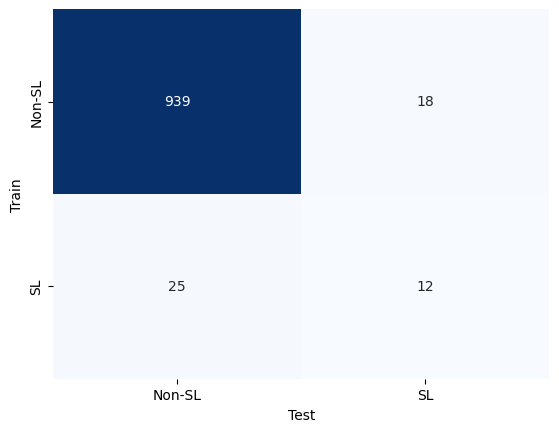

In [11]:
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Test")
plt.ylabel("Train")
plt.show()

In [12]:
# precision = TP/TP+FP
precision = 12/(12+18)
# precision = TP/TP+FN
recall = 12/(12+25)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 0.4
Recall: 0.32432432432432434
